Module 5, Lab 1 - Correlation
=============================

This final series of labs explores everything you need to execute
projects from start to finish based on a few different analyses.

In this lab, we will explore how to assess relationships between
variables using correlation in R.

In this example, we have a dataset, inspired by a dataset published on
kaggle (<https://www.kaggle.com/unsdsn/world-happiness>). In this
dataset, several regions of the world are compared on dimensions such as
their generosity, happiness, GDP, and so forth.

Load Packages
=============

In this lab, we will use the `ggplot2` package for data visualization,
the `corrplot` package for making visual correlation tables, and the
`psych` package for detecting skew and making correlation matrices.

In [36]:
## Load packages
import pandas as pd
import numpy as np
import scipy.stats as ss
import math
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

Load Data
=========

Next, let's load the data.

In [2]:
#### LOAD DATA ####
dat = pd. read_csv("datasets/regionalhappy.csv")

Inspecting the dataset, we see the names are a little messy:

In [3]:
dat.columns

Index(['Happiness.Score', 'Economy..GDP.per.Capita.', 'Family',
       'Health..Life.Expectancy.', 'Freedom', 'Generosity',
       'Trust..Government.Corruption.', 'Dystopia.Residual'],
      dtype='object')

We can rename them easily by assigning names to the `columns` attribute of the data frame:

In [7]:
dat.columns = ["Happiness", "GDP", "Family", "Life_Expect", "Freedom", "Generosity", "Trust_Gov", "Dystopia"]
dat.columns

Index(['Happiness', 'GDP', 'Family', 'Life_Expect', 'Freedom', 'Generosity',
       'Trust_Gov', 'Dystopia'],
      dtype='object')

Let's look at the first few rows of the data:

In [8]:
dat.head()

,Happiness,GDP,Family,Life_Expect,Freedom,Generosity,Trust_Gov,Dystopia
0,7.537,1.616463,1.533524,0.796667,0.635423,0.362012,0.315964,2.277027
1,7.522,1.482383,1.551122,0.792566,0.626007,0.355280,0.400770,2.313707
2,7.504,1.480633,1.610574,0.833552,0.627163,0.475540,0.153527,2.322715
3,7.494,1.564980,1.516912,0.858131,0.620071,0.290549,0.367007,2.276716
4,7.469,1.443572,1.540247,0.809158,0.617951,0.245483,0.382612,2.430182


Much better.

Bivariate Correlation
=====================

Next, let's see how variables correlate. In our research study, we want
to understand happiness. We can compute correlations between variables
with the Pandas `corr()` method. The upper or lower off-diagonal elements of the 2X2 correlation matrix contain the correlation coefficients. The Pandas `iloc` method allows you to address these elements using numerical indicies. 

In [30]:
corr_mat = dat[['Happiness', 'Life_Expect']].corr()
corr_mat.iloc[1,0].round(3)

0.782

We see the correlation is *r* = .78. A brief refresher: correlations
range between zero (no association between variables) and 1.0 (a
one-to-one association). They can also be positive (as one variable
increases, so does the other) or negative (as one variable increases,
the other decreases).

So, in this case, we have a large, positive link between the happiness
of a region and health / life expectancy in that region. The
statistician Jacob Cohen suggested the following guidelines:

|        | Correlation          | Meaning  |
| ------------- |:-------------:|-----------:|
| 1.  | 0 - 0.1 | Negligible |
| 2.  | 0.1 - 0.3     |  Small |
| 3. | 0.3 - 0.5      |  Medium |
| 4. | 0.50 +      |  Large |

We see, then, that this association would count as "large" by Cohen's
guidelines.

We can also easily visualize this correlation with `ggplot2`:

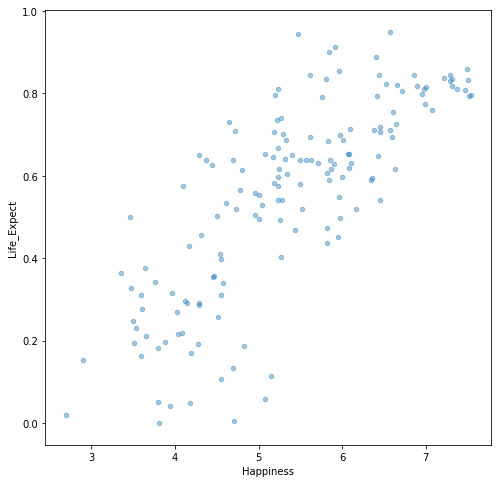

In [23]:
ax = plt.figure(figsize=(8, 8)).gca() # define axis
dat.plot.scatter(x = 'Happiness', y = 'Life_Expect', ax = ax, alpha = 0.4)

![](Mod3_Lab1_-_Correlation_files/figure-markdown_strict/unnamed-chunk-8-1.png)

### A Sample Estimate

We have discussed statistical hypothesis testing a number of times in
this course, but we haven't yet discussed it in detail with respect to
correlations. So, here is a brief refresher on the need for significance
testing, applied to correlation.

Here, are working with a sample of regions at one point in time. What if
we wanted to estimate, in a broader way, the association between
happiness and life expectancy? Assuming our data are representative of
the broader population (e.g., across times, regions, etc.; a big
assumption!), we could use this sample correlation (symbol: *r* = .78)
as an estimate of the population correlation (symbol: *ρ*). In other
words, we don't know the true correlation between happiness and life
expectancy in the population, but if we can trust this data to
adequately represent it, we can *estimate* it at .78.

The estimation piece is important. Often, people look at the sample
correlation and don't realize that it's specific to that sample. For
example, an organization might collect a survey to assess the link
between customer satisfaction and consumption. Whatever correlation
observed in the sample is only an estimate--our best guess--of the
correlation in the broader population. Were that organization to collect
another sample, they would get a different correlation. Every time, the
correlation would vary slightly, because the sample is different and
only representing (but not being) the population. This raises an
important point: sample correlations are imperfect estimates of their
population counterparts. The sample estimate has error built into it.

One important consequence is that it is possible that the correlation in
the population is actually zero (*H*<sub>0</sub> : *ρ* = 0) even when it
is not in the sample (e.g., *r* = .12). In other words, the sample
correlation could be a statistical fluke of the sample. We cannot say,
just because the sample correlation is nonzero, that the two variables
truly are correlated in the population. We will need to conduct a
statistical significance test first.

Further, we can *only* trust the sample correlation as an estimate of
the population correlation *if* the data are representative. If only a
certain kind of person selects into the survey (e.g., a certain
personality type, people who have strong feelings about a product,
etc.), then the sample correlation will estimate the correlation for
*that population only.* This essentially means that all research data is
biased toward whoever is over-represented in the sample. For this
reason, getting good information on whoever is represented in one's data
is very important for qualifying the results. In some cases, it may be
worth it to gather data from multiple different sources or methods and
cross-reference the results for very important decisions.

Significance Test
=================

If we want to test the correlation for significance, we can use the 'pearsonr' function from the scipy.stats modules. The confidence intervals can be computed using the methods in the functions below.

In [43]:
def r_z(r):
    return math.log((1 + r) / (1 - r)) / 2.0

def z_r(z):
    e = math.exp(2 * z)
    return((e - 1) / (e + 1))

def r_conf_int(r, alpha, n):
    # Transform r to z space
    z = r_z(r)
    # Compute standard error and critcal value in z
    se = 1.0 / math.sqrt(n - 3)
    z_crit = ss.norm.ppf(1 - alpha/2)

    ## Compute CIs with transform to r
    lo = z_r(z - z_crit * se)
    hi = z_r(z + z_crit * se)
    return (lo, hi)


pearson_cor = ss.pearsonr(x = dat['Happiness'], y = dat['Life_Expect'])
conf_ints = r_conf_int(corr_mat.iloc[1,0], 0.05, 1000)
print('Correlation = %4.3f with CI of %4.3f to %4.3f and p_value %4.3e' 
        % (pearson_cor[0], conf_ints[0], conf_ints[1], pearson_cor[1]))

Correlation = 0.782 with CI of 0.757 to 0.805 and p_value 3.213e-33


The confidence interval is fairly narrow around the correlation coefficient. 

Using the same information, we can make a reasonable guess about what
the correlation in the population is. We see that `cor.test()` has given
us a 95% confidence interval of \[0.71, 0.84\], meaning that we are 95%
confident that the population value (*ρ*) is in that range. By "95%
confident," we mean that this range includes the population value 95% of
the time. If we act on it and trust it, we are right 95% of the time.

So, we are pretty certain that, even though we have a sample (a small
sample, too!), that there is a large correlation in the population
between happiness and life satisfaction. Even after taking the
uncertainty of our sample into account (e.g., with the *t*-test and 95%
CI), we still feel confident that there is a larger link between these
two variables.

Caveat: Normality
=================

It should be noted that correlations work best with normally distributed
(bell curve, symmetrical) data. We can briefly check the skew of the
variables. I won't use `ggplot2` here since we aren't making figures
we'd want to share:

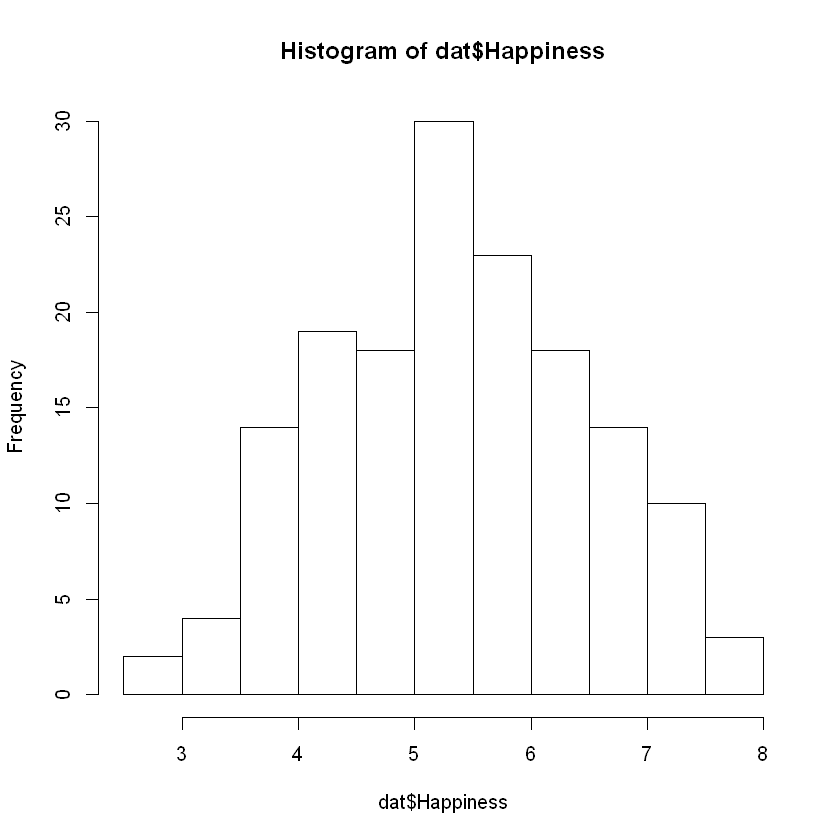

In [10]:
hist(dat$Happiness)

![](Mod3_Lab1_-_Correlation_files/figure-markdown_strict/unnamed-chunk-10-1.png)

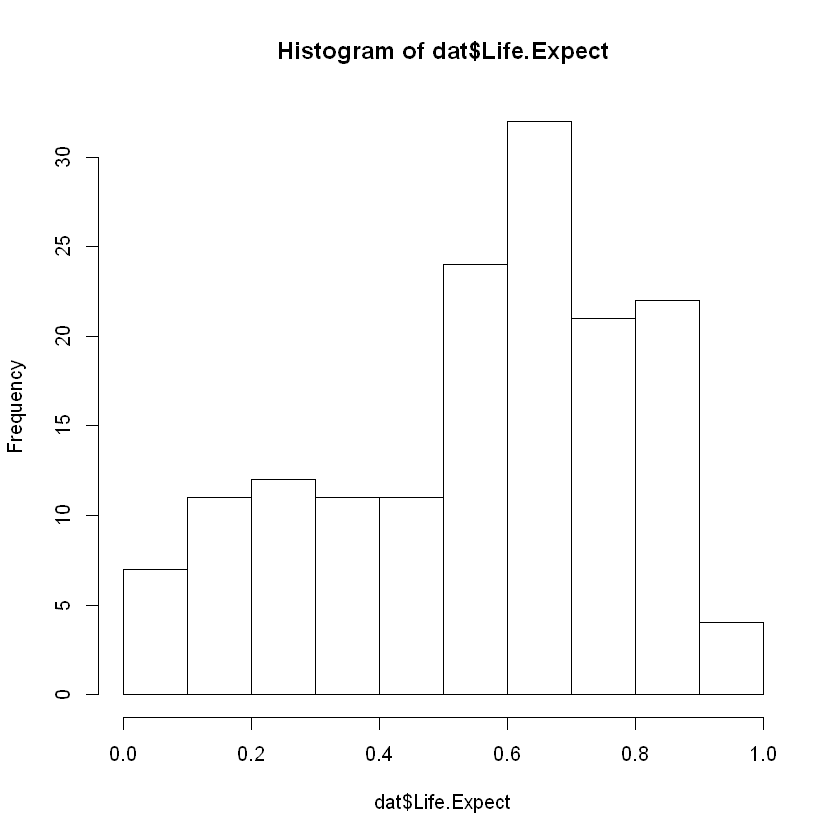

In [11]:
hist(dat$Life.Expect)

![](Mod3_Lab1_-_Correlation_files/figure-markdown_strict/unnamed-chunk-10-2.png)

We see here that both variables are decently normally distributed, but
life expectancy is possibly negative skewed (i.e., "skew left"). We can
get a metric of the skew using the `skew()` command in the `psych`
package:

In [12]:
psych::skew(dat$Life.Expect)

## [1] -0.5668279

[1] -0.5668279

People disagree about what is acceptable skew, but usually a value less
than +/- 1.0 raises no alarms. Here, we can safely go about our
business.

However, if we had a bigger skew problem, we could also address the skew
by transforming the variable. (There are also backup options, such as
Spearman's correlation, but we won't explore that in this class beyond
what was covered in Module 3).

Correlations are based on variance, so anything that biases a mean
(e.g., skew) also interferes with the correlation. In general, skew
reduces correlations. For a more robust test of the correlation, you can
transform the data by performing a mathematical operation to every
score. There are many such operations we can try. In general, taking the
square root of every score reduces skew, but the catch is that the
variable must be positively skewed and no scores may be negative. For
the sake of illustration, let's try this.

First, let's "reverse" the variable. Take the maximum score, add one to
it, and subtract your score:

In [13]:
dat$Life.Expect2 <- max(dat$Life.Expect) + 1 - dat$Life.Expect

This reverses the variable:

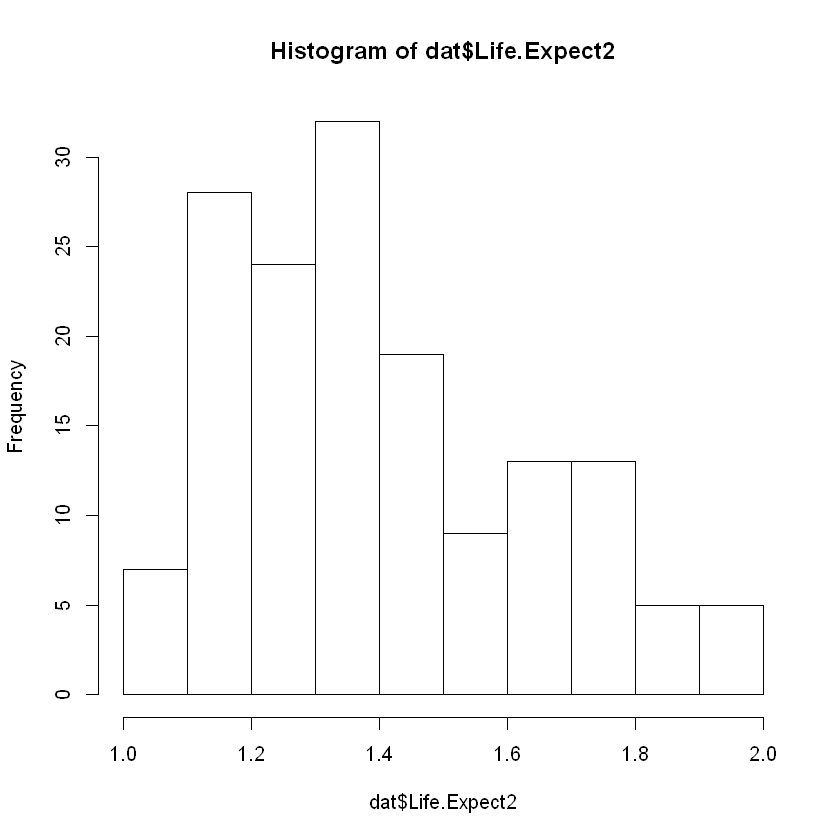

In [14]:
hist(dat$Life.Expect2)

![](Mod3_Lab1_-_Correlation_files/figure-markdown_strict/unnamed-chunk-13-1.png)

Now we can perform any number of operations. The square root is the most
mild transformation. We can also take the natural log of every score (no
values may be zero!). In general, these operations reduce big numbers
more than small numbers and thus rein in the long tail:

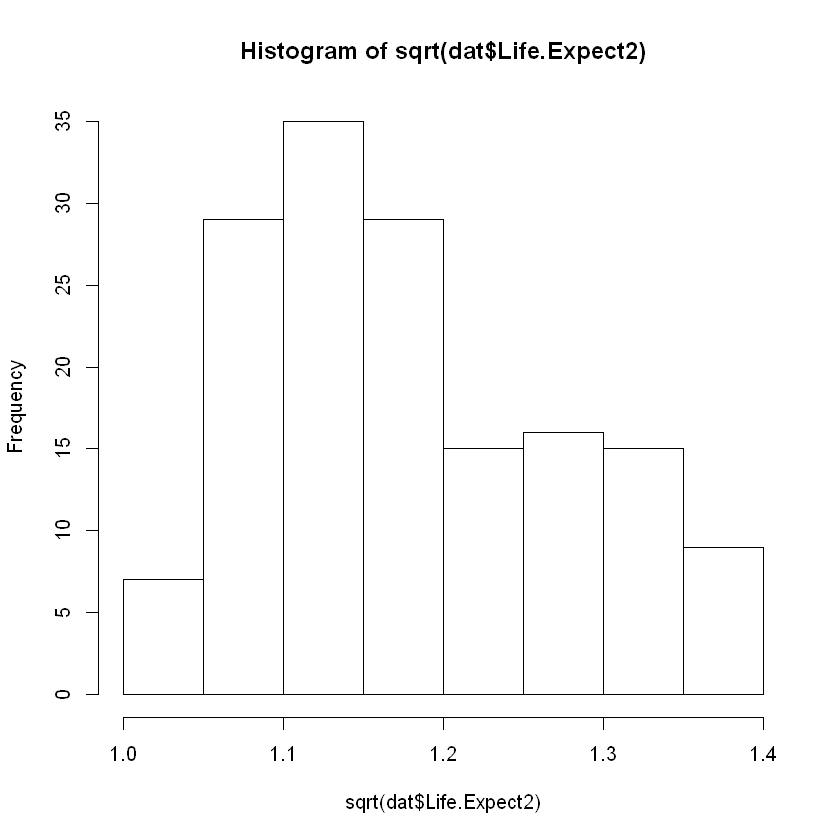

In [15]:
hist(sqrt(dat$Life.Expect2))

![](Mod3_Lab1_-_Correlation_files/figure-markdown_strict/unnamed-chunk-14-1.png)
We could save this transformed version, then re-reverse it and use that
in subsequent analyses.

In [16]:
dat$Life.Expect2 <- sqrt(dat$Life.Expect2)
dat$Life.Expect2 <- max(dat$Life.Expect2) + 1 - dat$Life.Expect2

cor.test(dat$Happiness, dat$Life.Expect2)

## 
##  Pearson's product-moment correlation
## 
## data:  dat$Happiness and dat$Life.Expect2
## t = 15.747, df = 153, p-value < 2.2e-16
## alternative hypothesis: true correlation is not equal to 0
## 95 percent confidence interval:
##  0.7177367 0.8399223
## sample estimates:
##       cor 
## 0.7864035


	Pearson's product-moment correlation

data:  dat$Happiness and dat$Life.Expect2
t = 15.747, df = 153, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.7177367 0.8399223
sample estimates:
      cor 
0.7864035 


We see here the results barely changed. In this case, that wasn't really
necessary because the variable was not that skewed to begin with. You
will find, in many cases, that it is very helpful, however. In those
cases, there are many online guides to data transformation.

Of course, if you are predicting something that has a very non-normal
distribution (e.g., categorical variables, counts of things often have
many zeros, etc.) then correlation may not be the best tool to use. A
more sophisticated data modeling technique may be warranted. However,

Correlations Among Many Variables
=================================

Often we want to examine the correlations among many variables at once.
In this case, we could look at a matrix of correlations. This can be
done by inputting a data.frame of all the variables of interest into the
`cor()` function:

You can make your own data.frame of just the variables you want to
analyze, or we could simply use `dat`. Here, I want happiness, life
expectancy, GDP, and generosity:

In [17]:
cor(data.frame(dat$Happiness, dat$Life.Expect, dat$GDP, dat$Generosity))

##                 dat.Happiness dat.Life.Expect     dat.GDP dat.Generosity
## dat.Happiness       1.0000000      0.78195062  0.81246875     0.15525584
## dat.Life.Expect     0.7819506      1.00000000  0.84307664     0.06319149
## dat.GDP             0.8124688      0.84307664  1.00000000    -0.01901125
## dat.Generosity      0.1552558      0.06319149 -0.01901125     1.00000000

,dat.Happiness,dat.Life.Expect,dat.GDP,dat.Generosity
dat.Happiness,1.0000000,0.78195062,0.81246875,0.15525584
dat.Life.Expect,0.7819506,1.00000000,0.84307664,0.06319149
dat.GDP,0.8124688,0.84307664,1.00000000,-0.01901125
dat.Generosity,0.1552558,0.06319149,-0.01901125,1.00000000


We can easily see that happiness, life expectancy, and GDP are all
highly intercorrelated, whereas generosity is seemingly less related.
Thus, we may conceive that we have a "cluster" of intercorrelated
variables around happiness.

If you wanted significance tests, you can request that with the
`corr.test()` function in the `psych` package, which returns a grid of
*p*-values. This will also give you other contents; we can request only
the *p*-values by adding `$p` at the end.

In [18]:
corr.test(data.frame(dat$Happiness, dat$Life.Expect, dat$GDP, dat$Generosity))$p

##                 dat.Happiness dat.Life.Expect  dat.GDP dat.Generosity
## dat.Happiness       0.0000000       0.0000000 0.000000      0.1611975
## dat.Life.Expect     0.0000000       0.0000000 0.000000      0.8694396
## dat.GDP             0.0000000       0.0000000 0.000000      0.8694396
## dat.Generosity      0.0537325       0.4347198 0.814369      0.0000000

,dat.Happiness,dat.Life.Expect,dat.GDP,dat.Generosity
dat.Happiness,0.000000e+00,1.285188e-32,5.551953e-37,0.1611975
dat.Life.Expect,3.212970e-33,0.000000e+00,2.781039e-42,0.8694396
dat.GDP,1.110391e-37,4.635065e-43,0.000000e+00,0.8694396
dat.Generosity,5.373250e-02,4.347198e-01,8.143690e-01,0.0000000


Note that only the correlations below the diagonal are correct. The ones
above the diagonal have been adjusted, but we won't deal with that here.
We do see that generosity is not significantly correlated with the other
variables.

#### Clustering

We saw before we had a cluster of several overlapping variables. We can
make some helpful visuals to view this cluster. The `heatmap()` command
highlights highly intercorrelated variables. It also produces a
dendrogram to show the clustering. I will do this for the full dataset,
less the `Life.Expect2` variable (which is redundant to the
non-transformed version). This is column 9, so I can easily drop it by
calling `dat[,-9]`:

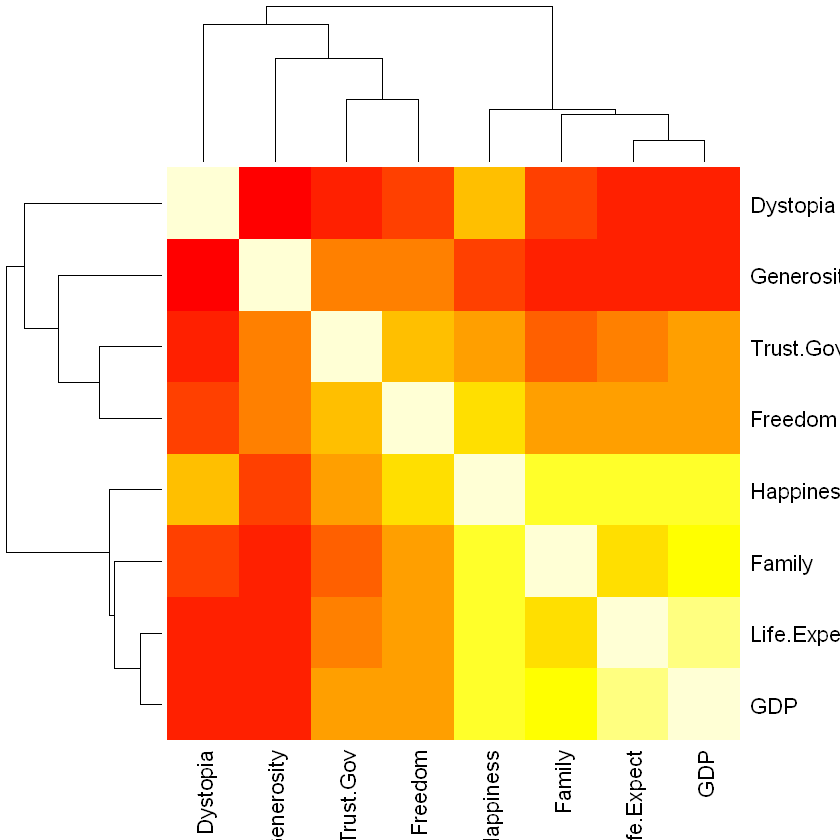

In [19]:
# save cor matrix
cors <- cor(dat[,-9])

#heatmap
heatmap(cors, symm = TRUE)

![](Mod3_Lab1_-_Correlation_files/figure-markdown_strict/unnamed-chunk-18-1.png)

Here we see there is a prominent cluster of happiness, family, life
expectancy, and GDP. These are all highly inter-correlated. You can see
this from the bright spot in the histogram as well as from the "long"
stem on the dendrogram for those variables (indicates greater
clustering).

#### A Correlation Plot

Another great visual is the correlation plot. This visual helps to map
out the sample correlations but with a greater emphasis on the
individuals relationships (rather than clustering).

There are many great tutorials for using the `corrplot` package online.
In general, like `heatmap()`, it accepts your correlation grid as an
input:

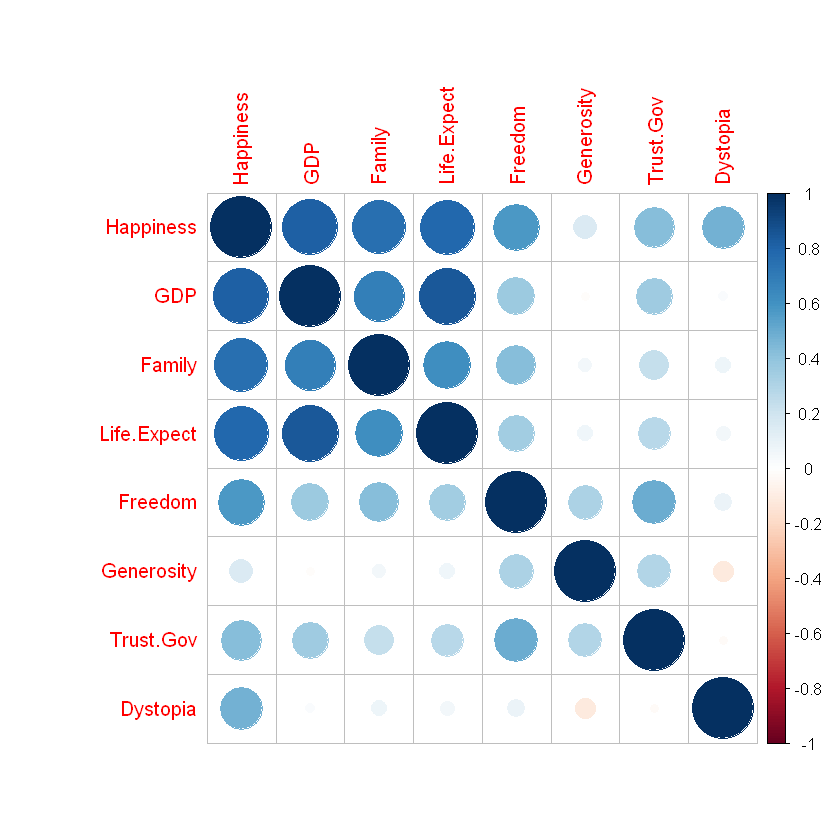

In [20]:
corrplot(cors)

![](Mod3_Lab1_-_Correlation_files/figure-markdown_strict/unnamed-chunk-19-1.png)

By default, it replaces the numbers in the grid with shapes
(lager/darker = stronger correlation; blue = pos, red = neg). Unlike
`heatmap()`, it does not sort the variables into clusters for us.
However, it has a lot of flexibility. Using `corplot.mixed()` you can
request numbers in one diagonal. You can also sort by the clustering
algorithm as in `heatmap()` by adding `order="hclust"`:

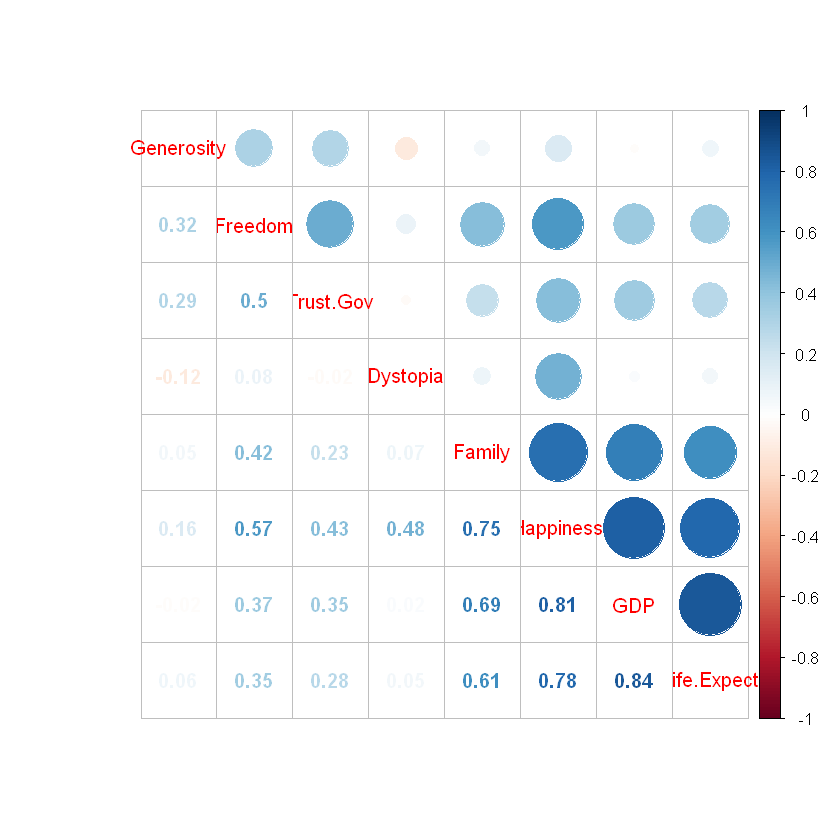

In [21]:
corrplot.mixed(cors, order="hclust")

![](Mod3_Lab1_-_Correlation_files/figure-markdown_strict/unnamed-chunk-20-1.png)

We can also add a grid of *p*-values with `p.mat=` and tell the function
to "X" out anything not &lt; .05 by adding `sig.level = .05`:

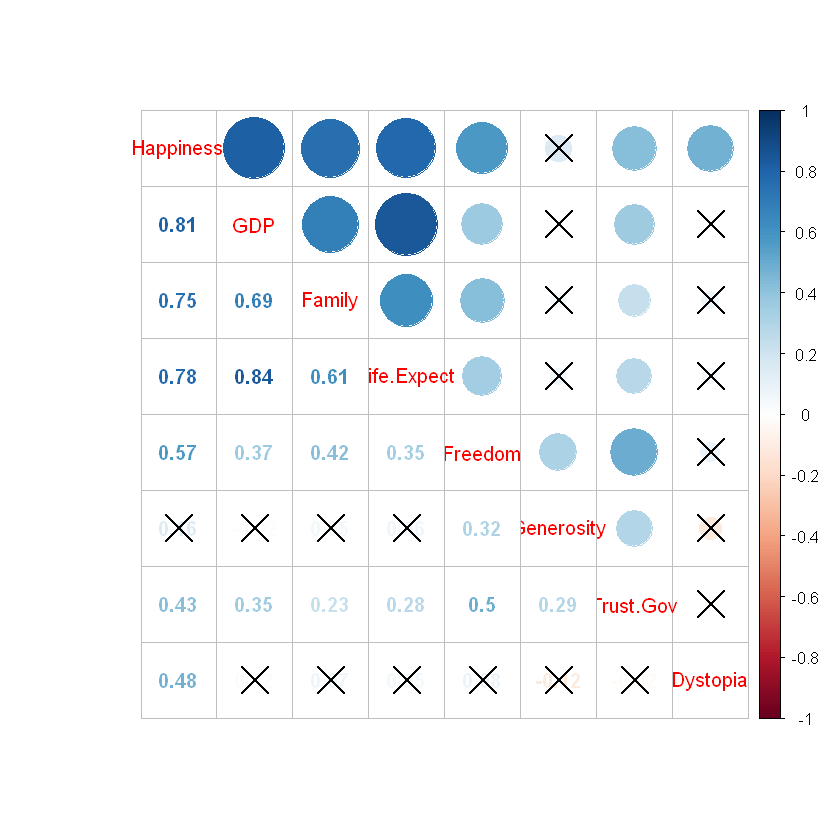

In [22]:
corrplot.mixed(cors,
               p.mat=corr.test(dat[,-9])$p, sig.level = .05)

![](Mod3_Lab1_-_Correlation_files/figure-markdown_strict/unnamed-chunk-21-1.png)

There you have it. There are many great ways to illustrate correlations
among data.

Conclusion
==========

Using the correlation analysis, we have both learned to find clusters of
relationships among data and to estimate individual correlations and
test them for significance. If we had a specific variable we wanted to
study in greater detail, we could graduate to regression, which we will
do in the next lab.